# **creating the cds and noncds mutation models**

In [1]:
import pysam 
from Bio import AlignIO
from tqdm import tqdm 
import json 
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.pyplot import figure

**getting the annotation file**

In [3]:
!cp /research/references/hsapiens/hg38/hg38.ncbiRefSeq.gtf.gz data/

In [11]:
!gunzip data/hg38.ncbiRefSeq.gtf.gz

In [12]:
%%bash 
(grep ^"#" data/hg38.ncbiRefSeq.gtf; grep -v ^"#" data/hg38.ncbiRefSeq.gtf | sort -k1,1 -k4,4n) | bgzip > data/hg38.ncbiRefSeq_sortedgff.bgz

In [13]:
!tabix -p gff data/hg38.ncbiRefSeq_sortedgff.bgz

In [32]:
!zcat data/hg38.ncbiRefSeq_sortedgff.bgz| cut -f 3 | sort | uniq -c 
#so this gff is of coding regions only 

 127169 3UTR
 247915 5UTR
1440848 CDS
1911608 exon
 118545 start_codon
 118439 stop_codon
 166923 transcript


**generating the fastas dictionary** 

In [10]:
list_chroms = ['chr' + str(i) for i in range(1, 23)]
fastas_dict = {}   # creating dictionary with fasta alignment, length of seq, 
for chrom in list_chroms:
    filename_tmp = "data/hg38_seq/{c}.fa".format(c=chrom)
    fastas_dict[chrom] = []
    fastas_dict[chrom].append(AlignIO.read(open(filename_tmp),"fasta"))
    alignment_tmp = fastas_dict[chrom][0]
    fastas_dict[chrom].append(len(str(alignment_tmp[0].seq)))

**reading in mutationfile**

In [11]:
mutations_lines = open("data/nature24018-s2/Aging_Oocytes_Supplementary_Table_DNMs_wrangled_unique.tsv").readlines()

## **making the cds and nonCds mutation dictionaries**

In [53]:
coding_muts = {}
noncoding_muts = {}
intron_muts = {}
bases = ["A","T","G","C"]
for base1 in bases: 
    for base2 in bases: 
        for base3 in bases: 
            coding_muts[base1+base2+base3] = [0,{}]
            noncoding_muts[base1+base2+base3] = [0,{}]
            intron_muts[base1+base2+base3] = [0,{}]
            for base_changing in bases: 
                if base_changing != base2: 
                    coding_muts[base1+base2+base3][1][base1+base_changing+base3] = 0
                    noncoding_muts[base1+base2+base3][1][base1+base_changing+base3] = 0
                    intron_muts[base1+base2+base3][1][base1+base_changing+base3] = 0


In [59]:
list_fuck_ups = []
indels = []
gff_filename = "data/hg38.ncbiRefSeq_sortedgff.bgz"

for line in tqdm(mutations_lines[1:]): 
    chrom = line.split()[0]
    if chrom in list_chroms:
        site = int(line.split()[1])
        #print(site)

        alignment = fastas_dict[chrom][0]

        Ref_bp = line.split()[2].upper()
        New_bp = line.split()[3].upper()
        Ref_triplet= (str(alignment[0,site-2:site+1].seq)).upper() #tried and true values (the mutations file is 1-based so need to sub)
        New_triplet = (str(alignment[0,site-2])+str(New_bp)+str(alignment[0,site])).upper()

        if Ref_triplet == New_triplet: 
            #print(Ref_triplet +" "+New_triplet+" "+str(row_split_tmp[0])+"    "++"   "+(str(alignment[0,site[1]-2])+" "+Ref_bp+"   "+str(alignment[0,site[1]])+" "+New_bp)
            list_fuck_ups.append([Ref_triplet, New_triplet, line.split()])
        elif  len(Ref_triplet) == 3 and  len(New_triplet)==3 and "N" not in Ref_triplet: 
            #ok now time to add to dictionary 
            if not [record for record in pysam.Tabixfile(gff_filename).fetch(chrom, site, site+1)]: #both the gff and mutations file are 1-based
                noncoding_muts[Ref_triplet][0]+=1
                noncoding_muts[Ref_triplet][1][New_triplet] += 1 
            else: 
                seqcrec = [record for record in pysam.Tabixfile(gff_filename).fetch(chrom, site, site+1)]
                if any("CDS" in s for s in seqcrec) or any("exon" in s for s in seqcrec): #https://stackoverflow.com/questions/4843158/how-to-check-if-a-string-is-a-substring-of-items-in-a-list-of-strings
                    coding_muts[Ref_triplet][0]+=1
                    coding_muts[Ref_triplet][1][New_triplet] += 1 
                else: #all those that return a value but not inthe CDs or exon should be 
                    intron_muts[Ref_triplet][0]+=1
                    intron_muts[Ref_triplet][1][New_triplet] += 1                 
 
        else: 
            assert len(New_bp) >= 1
            indels.append([Ref_triplet, New_triplet, line.split()]) # we dont want to include indels in our model anyways 

    

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100437/100437 [1:04:18<00:00, 26.03it/s]


In [61]:
intron_muts["AAA"], coding_muts["AAA"]

([888, {'ATA': 153, 'AGA': 483, 'ACA': 252}],
 [76, {'ATA': 14, 'AGA': 41, 'ACA': 21}])

In [64]:
with open('MutDict_coding_2021_09_16.txt', 'w') as outfile:
    json.dump(coding_muts, outfile)

In [63]:
with open('MutDict_intergenic_2021_09_16.txt', 'w') as outfile:
    json.dump(noncoding_muts, outfile)
    
with open('MutDict_intron_2021_09_16.txt', 'w') as outfile:
    json.dump(intron_muts, outfile)

In [65]:
sum_coding = 0
sum_noncoding = 0
sum_intron = 0
for val in coding_muts.values(): 
    sum_coding+=val[0]
for val in noncoding_muts.values(): 
    sum_noncoding+=val[0]
for val in intron_muts.values(): 
    sum_intron+=val[0]
print(sum_coding+ sum_noncoding+sum_intron+ len(indels) - len(mutations_lines), "mutations excluded as they are in sex chromosomes")
print(sum_coding,"coding mutations")
print(sum_noncoding, "noncoding mutations")
print(sum_intron, "intron mutations")

-2 mutations excluded as they are in sex chromosomes
4902 coding mutations
42486 noncoding mutations
51115 intron mutations


# **ok make the model**

In [20]:
#importing the triplet coutns 
coding_trips = json.load(open("tripCount_cds_2021_09_15_robFile.txt"))
noncoding_trips = json.load(open("tripCount_nonCds_2021_09_15.txt"))

In [21]:
#importing the triplet coutns 
coding_muts = json.load(open("MutDict_coding_2021_09_16.txt"))
noncoding_muts= json.load(open("MutDict_intergenic_2021_09_16.txt"))

In [22]:
coding_sum = 0
noncoding_sum = 0
for val in coding_trips.values(): 
    coding_sum+=val
for val in noncoding_trips.values(): 
    noncoding_sum+=val

In [23]:
print("number of triplets from the coding fasta is",coding_sum)
print("number of triplets from the intergenic fasta is", noncoding_sum)

number of triplets from the coding fasta is 35258968
number of triplets from the intergenic fasta is 1632537318


In [24]:
coding_sum = 0
noncoding_sum = 0
for val in coding_muts.values(): 
    coding_sum+=val[0]
for val in noncoding_muts.values(): 
    noncoding_sum+=val[0]

In [25]:
print("number of mutations from the cds",coding_sum)
print("number of mutations from the intergenic", noncoding_sum)

number of mutations from the cds 4902
number of mutations from the intergenic 42486


In [26]:
coding_model = {}
coding_live_sum = 0
for key, item in coding_muts.items(): 
    n_muts = item[0]
    n_trips = coding_trips[key]
    mut = n_muts/n_trips
    coding_live_sum+=n_muts
    into_dict = {}
    for into_trip_key,value in item[1].items(): 
        into_dict[into_trip_key] = value/n_muts
    
    coding_model[key] = [mut,into_dict]

In [27]:
noncoding_model = {}
for key, item in noncoding_muts.items(): 
    n_muts = item[0]
    n_trips = noncoding_trips[key]
    mut = n_muts/n_trips
    
    into_dict = {}
    for into_trip_key,value in item[1].items(): 
        into_dict[into_trip_key] = value/n_muts
    
    noncoding_model[key] = [mut,into_dict]

In [28]:
with open('Model_2021_09_17_codingNoIntrons_robfile.txt', 'w') as outfile:
    json.dump(coding_model, outfile)

In [74]:
with open('Model_2021_09_17_nonCoding.txt', 'w') as outfile:
    json.dump(noncoding_model, outfile)

# **analysing the models a bit**

In [29]:
coding_muts_list = []
noncoding_muts_list = []
triplets = []
for triplet,val in coding_model.items(): 
    triplets.append(triplet)
    coding_muts_list.append(val[0])
    noncoding_muts_list.append(noncoding_model[triplet][0])

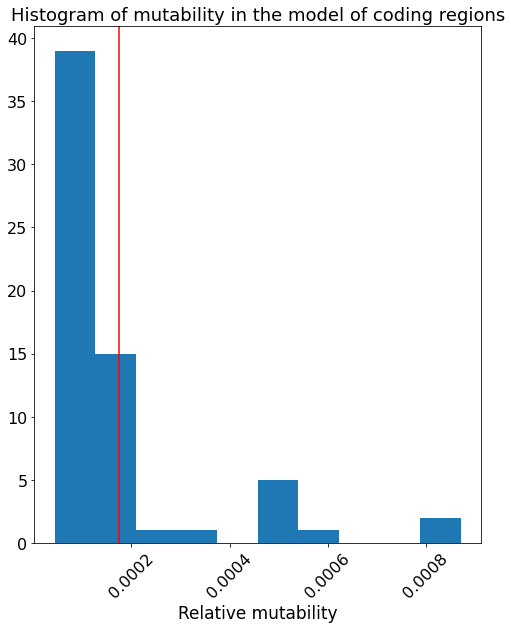

In [39]:
figure(figsize=(8, 9.5))#https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
plt.hist(coding_muts_list)
plt.xlabel("Relative mutability", size=17)
plt.xticks(rotation=45, size = 16)
plt.yticks(size = 16)
plt.title("Histogram of mutability in the model of coding regions", size = 18)
plt.axvline(x=np.mean(coding_muts_list), color="red")
# plt.savefig("plots/mutabilityHistogram_codingModel_2021_09_17_noIntrons_nonverlapCDS.png")

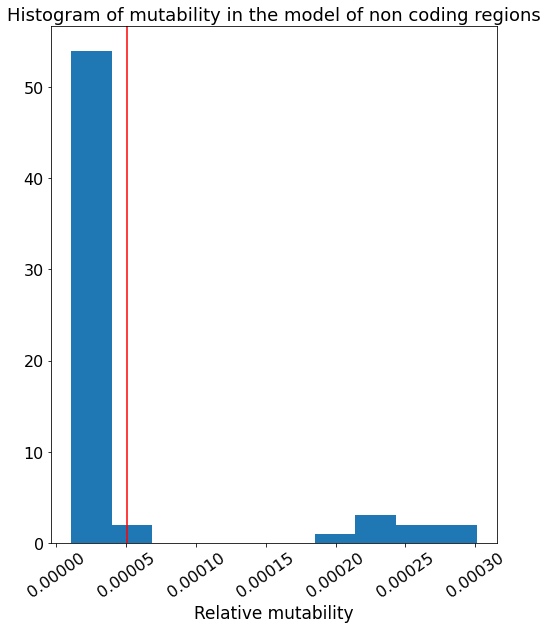

In [31]:
figure(figsize=(8, 9.5))#https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
plt.hist(noncoding_muts_list)
plt.xlabel("Relative mutability", size=17)
plt.xticks(rotation=35, size = 16)
# plt.xticks( size = 16)
plt.yticks(size = 16)
plt.title("Histogram of mutability in the model of non coding regions", size = 18)
plt.axvline(x=np.mean(noncoding_muts_list), color="red")
# plt.savefig("plots/mutabilityHistogram_noncodingModel_2021_09_17.png")

In [37]:
print("average coding model mutability is",np.mean(coding_muts_list),"plus or minus",np.std(coding_muts_list)/np.sqrt(len(coding_muts)))

average coding model mutability is 0.00017513023854836952 plus or minus 2.1867692658684335e-05


In [38]:
print("average noncoding model mutability is",np.mean(noncoding_muts_list),"plus or minus",np.std(noncoding_muts_list)/np.sqrt(len(noncoding_muts)))

average noncoding model mutability is 5.0791956211746186e-05 plus or minus 9.495964712774053e-06


In [34]:
"coding is",np.mean(coding_muts_list)/np.mean(noncoding_muts_list),"the size of noncoding"

('coding is', 3.447991603597043, 'the size of noncoding')

In [83]:
4902/252889160=1.93e-05, 42486/ 1632537318 = 2.60e-05

(1.938398624915358e-05, 2.602451994913601e-05)

In [90]:
for t,c,n in zip(triplets,coding_muts,noncoding_muts): 
    print(t,(c-n)/c)

AAA 0.1917372258945301
AAT 0.28893577239057566
AAG -0.7723723666846148
AAC -0.44875531671252167
ATA 0.38333446739786564
ATT 0.05689959534300203
ATG -0.4901164439981584
ATC -1.1091824412986975
AGA -0.7727437990563057
AGT -0.46358305065754823
AGG -0.4447352568238197
AGC -0.7381048565184309
ACA -0.5240269455804824
ACT -0.2939148739920923
ACG -1.8745390076510873
ACC -0.9221324268136362
TAA 0.31422191418450235
TAT -0.11978264164034579
TAG 0.006512753060956394
TAC -0.4941681214025034
TTA 0.25494479685787563
TTT 0.3372018005344883
TTG -0.33744628442034086
TTC -0.4791826204182796
TGA -0.678143302795735
TGT -0.4039941478915061
TGG -0.8867049549113131
TGC -0.6203638119757212
TCA -0.44650523229527156
TCT -0.03472159588559103
TCG -1.4088400785247988
TCC -0.39215931734906184
GAA -0.6048422473346948
GAT -1.2125314895332393
GAG -0.7722438601502805
GAC -0.9526610978759787
GTA 0.026928019271543157
GTT -0.09887262784663622
GTG -0.4906933211700909
GTC -0.9577231665527854
GGA -1.0596284318150264
GGT -0.46

In [ ]:
coding_model["CGC"]